In [1]:
import numpy
import h5py
import pandas

from toposample import Config, data
from figure_helper import FigureHelper
from helper_functions import Percentile, Normalizer
from pandas_helper import column_names_to_values
from toposample.db import get_column_from_database
from toposample.data import read_h5_dataset

"""
Main config file. This file specifies the paths to all the result files and allows us to read the results.
"""
cfg = Config("../working_dir_mn_sz50/config/common_config.json")

"""
Additional parameterization, like which examples to plot and in which color
"""
# Order in which to plot the results
spec_parameters = ['Transitive clustering coefficient', 'Adjacency spectral gap (low)', 'Relative boundary', 'Fourth density coefficient', 'Normalized Betti coefficient', 'Fifth density coefficient', 'Afferent extension rate', 'Out-degree', 'In-degree', 'Efferent extension rate', 'Euler characteristic']

spec_comm_coupling = ['Community coupling', 'Mean tribe community coupling']

"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()
F = fhlpr("Figure 4")
S = fhlpr("Figure S4")
F5 = fhlpr("Figure 5")

In [2]:
"""
Files we are going to load
"""
tribe_struc_params_fn = cfg._cfg['analyzed']['struc_parameters']
tribe_triads_fn = cfg._cfg['analyzed']['triads']
tribe_gids_fn = cfg._cfg['analyzed']['tribes']
db_fn = cfg._cfg['analyzed']['database']
tribe_accuracy_fn = cfg._cfg['analyzed']['classifier_components_results']

"""
Load the data
"""
acc_reader = read_h5_dataset("scores")  # Loading function to extract the accuracy

tribe_struc_params = data.TopoData(tribe_struc_params_fn)
tribe_triads = data.TopoData(tribe_triads_fn)['overexpression'].map(numpy.array)
tribe_gids = data.TopoData(tribe_gids_fn)['gids']
db = pandas.read_pickle(db_fn)
data_acc = data.TopoData(tribe_accuracy_fn, follow_link_functions={"data_fn": (acc_reader, True)})['data_fn']
param_definitions = cfg.stage("struc_tribe_analysis")["config"]["Parameters"]


In [3]:
"""
Some basic analysis that will help in the future.
"""
#  We sort the order of parameters by their accuracy in the manifold task
tribe_pooled_acc = data_acc.pool(["index"], func=numpy.hstack)
tribe_mean_acc = tribe_pooled_acc.map(numpy.nanmean)
tribe_sd_acc = tribe_pooled_acc.map(numpy.nanstd)
idxx = numpy.argsort([tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
                      for spec in spec_parameters])
spec_parameters = [spec_parameters[i] for i in idxx]

# Add the size of the associated tribe as a structural parameter
tribe_size = tribe_gids.map(len)
tribe_struc_params.data["Tribe size"] = tribe_size

# For the volumetric samples add the mean of the tribe lengths of contained neurons
all_lengths = db["tribe"].apply(len)
mean_lengths = tribe_gids.filter(sampling="Radius").map(lambda x: numpy.mean(all_lengths.loc[x]))
tribe_struc_params.data["Mean size"] = mean_lengths

# override one specific parameter that is not properly calculated for volumetric samples
tribe_struc_params.data["Mean tribe community coupling"] =\
tribe_gids.map(lambda x: numpy.nanmean(db["comm_coupling"].loc[x]))

#  Helper function: For a given parameter find all its "subsampled" versions and return them in order
def find_subsampled(base_parameter, data_struc=None):
    if data_struc is None:
        data_struc = data_acc
    subs_specs = data_struc.filter(sampling="subsampled").labels_of("specifier")
    ret_x = []
    ret_specs = []
    for spec in subs_specs:
        spec_name, spec_val = spec.split("@")
        if spec_name != base_parameter:
            continue
        ret_x.append(int(spec_val))
        ret_specs.append(spec)
    idxx = numpy.argsort(ret_x)
    return [ret_x[i] for i in idxx], [ret_specs[i] for i in idxx]


<ipython-input-3-8a5fc9d27929>:23: RuntimeWarning: Mean of empty slice
  tribe_gids.map(lambda x: numpy.nanmean(db["comm_coupling"].loc[x]))


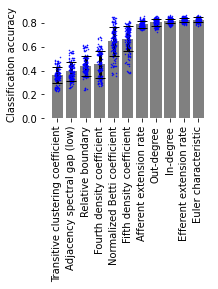

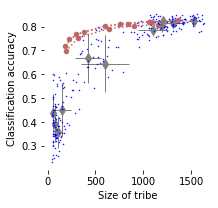

In [4]:
"""
Figure panel: Accuracies for the champions of the various parameters
"""
from matplotlib import pyplot as plt

plot_mean_acc = [tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
                for spec in spec_parameters]
plot_sd_acc = [tribe_sd_acc.get2(sampling="Parameter", specifier=spec)
               for spec in spec_parameters]

fig = plt.figure(figsize=(3, 2))
ax = fig.gca()

ax.bar(range(len(plot_mean_acc)), plot_mean_acc, color='grey')
for x, spec in enumerate(spec_parameters):
    y = tribe_pooled_acc.get2(sampling="Parameter", specifier=spec)
    ax.plot(x + 0.35 * (numpy.random.rand(len(y)) - 0.5), y, marker='.', ms=1., color='blue', ls='None')
ax.errorbar(range(len(plot_mean_acc)), plot_mean_acc, yerr=plot_sd_acc,
            ls='None', color='black', elinewidth=3, capsize=5)
    
ax.set_xticks(range(len(spec_parameters)))
_ = ax.set_xticklabels(spec_parameters, rotation='vertical')
ax.set_ylabel("Classification accuracy")
plt.box(False)
F.save(fig, fn="Panel-A")

"""
Figure panel: Accuracies vs. sizes of the tribes
"""
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

# averages the accuracy of cross-val. iterations, but not across champions of a parameter
tribe_nonpooled_mean_acc = data_acc.map(numpy.nanmean)
tribe_mean_size = tribe_size.pool(["index"], func=numpy.mean)
for spec in spec_parameters:
    index, x = tribe_size.get_x_y("index", sampling="Parameter", specifier=spec)
    mean_x = tribe_mean_size.get2(sampling="Parameter", specifier=spec)
    y = [tribe_nonpooled_mean_acc.get2(sampling="Parameter", specifier=spec, index=idx) for idx in index]
    mean_y = tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
    
    _, subs_spec = find_subsampled(spec)
    if len(subs_spec):
        subs_x = [tribe_mean_size.get2(sampling="subsampled", specifier=_spec) for _spec in subs_spec]
        subs_y = [tribe_mean_acc.get2(sampling="subsampled", specifier=_spec) for _spec in subs_spec]
        ax.plot(subs_x + [mean_x], subs_y + [mean_y], color=[0.75, 0.4, 0.4], marker="o", ms=4.5, ls=":")

    ax.plot(mean_x, mean_y, ls="None", marker="d", ms=7, color='grey')
    ax.errorbar(mean_x, mean_y, xerr=numpy.std(x), yerr=numpy.std(y), lw=0.5, color='black')
    ax.plot(x, y, ls="None", marker='.', ms=1, color='blue')
    ax.set_xlabel("Size of tribe")
    ax.set_ylabel("Classification accuracy")
plt.box(False)
F.save(fig, fn="Panel-B")

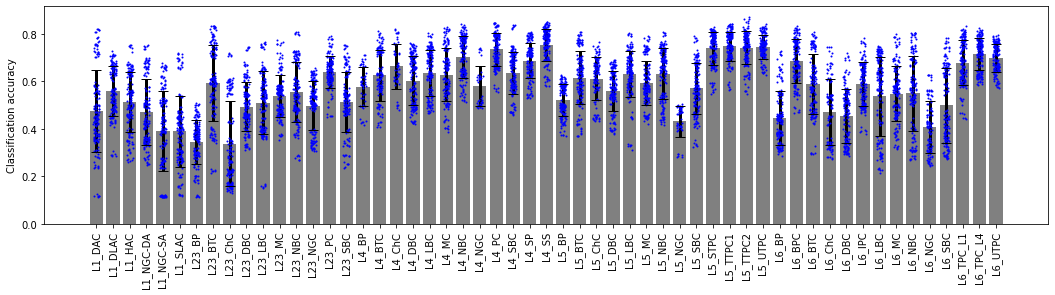

In [5]:
"""
Figure panel: Accuracies for the randomly sampled tribes
"""
spec_mtypes = tribe_mean_acc.filter(sampling="M-type").labels_of("specifier")
plot_mean_acc = [tribe_mean_acc.get2(sampling="M-type", specifier=spec)
                for spec in spec_mtypes]
plot_sd_acc = [tribe_sd_acc.get2(sampling="M-type", specifier=spec)
               for spec in spec_mtypes]

fig = plt.figure(figsize=(18, 4))
ax = fig.gca()

ax.bar(range(len(plot_mean_acc)), plot_mean_acc, color='grey')
for x, spec in enumerate(spec_mtypes):
    y = tribe_pooled_acc.get2(sampling="M-type", specifier=spec)
    ax.plot(x + 0.35 * (numpy.random.rand(len(y)) - 0.5), y, marker='.', ms=2, color='blue', ls='None')
ax.errorbar(range(len(plot_mean_acc)), plot_mean_acc, yerr=plot_sd_acc,
            ls='None', color='black', elinewidth=3, capsize=5)
    
ax.set_xticks(range(len(spec_mtypes)))
_ = ax.set_xticklabels(spec_mtypes, rotation='vertical')
ax.set_ylabel("Classification accuracy")

S.save(fig, fn="Panel-A")

,specifier,Accuracy,Transitive_clustering_coefficient,Adjacency_spectral_gap_low,Relative_boundary,Fourth_density_coefficient,Normalized_Betti_coefficient,Fifth_density_coefficient,Afferent_extension_rate,Outdegree,Indegree,Efferent_extension_rate,Euler_characteristic,Tribe_size
0,L23_MC,0.645717,0.0295,0.0001,26.3750,4.314920e-07,0.0766,0.0,22766.0,668.0,57.0,25968.0,467.0,719
1,L23_MC,0.549592,0.0288,0.0001,25.6221,4.814953e-07,0.2113,0.0,21366.0,603.0,155.0,25685.0,893.0,741
2,L23_MC,0.425473,0.0455,0.0004,62.4744,0.000000e+00,0.1615,0.0,13213.0,123.0,53.0,15935.0,13.0,174
3,L23_MC,0.477290,0.0382,0.0001,61.6815,0.000000e+00,0.1125,0.0,13552.0,137.0,54.0,16474.0,26.0,192
4,L23_MC,0.508435,0.0349,0.0011,54.0406,6.647310e-07,0.1202,0.0,18842.0,243.0,75.0,23415.0,13.0,318


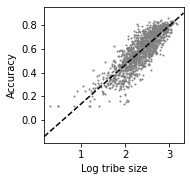

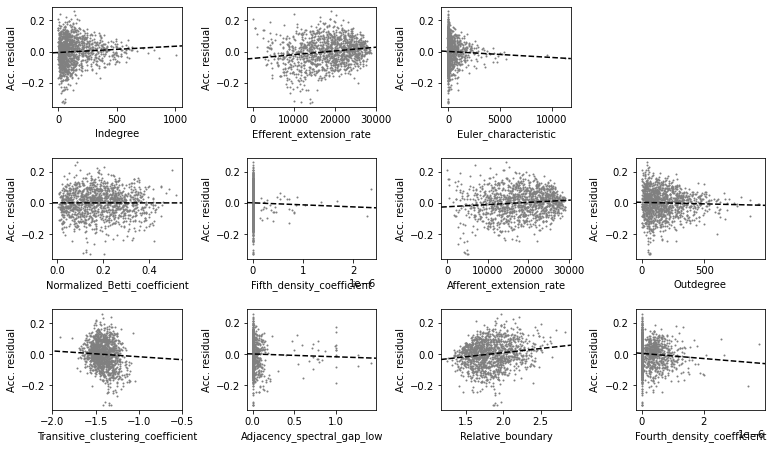

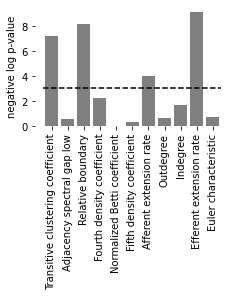

In [6]:
from pandas_helper import assemble_result_dataframe
from statsmodels.formula.api import ols

dframe_random_tribes = assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params,
                                                 sampling="M-type",
                                                 parameters_to_add=spec_parameters + ["Tribe size"])
display(dframe_random_tribes.head())

dframe_random_tribes["Log_tribe_size"] = numpy.log10(dframe_random_tribes["Tribe_size"])
model = ols("Accuracy ~ Log_tribe_size", data=dframe_random_tribes).fit()
dframe_random_tribes["Accuracy_residual"] = model.resid.values
#dframe_random_tribes["Accuracy"] - \
#                                            model.predict(dframe_random_tribes)

fig = plt.figure(figsize=(2.5, 2.5))
ax = fig.gca()
ax.plot(dframe_random_tribes["Log_tribe_size"], dframe_random_tribes["Accuracy"], '.', ms=2, color='grey')
xx = ax.get_xlim()
ax.set_xlim(xx)
ax.plot(xx, model.params["Intercept"] + model.params["Log_tribe_size"] * numpy.array(xx),
        ls='--', color='black')
ax.set_xlabel("Log tribe size")
ax.set_ylabel("Accuracy")
S.save(fig, fn="Panel-B")

dframe_random_tribes.pop("Accuracy"); dframe_random_tribes.pop("Tribe_size");
dframe_random_tribes.pop("Log_tribe_size")

for col_name in ["Transitive_clustering_coefficient", "Relative_boundary"]:
    dframe_random_tribes[col_name] = numpy.log10(dframe_random_tribes[col_name] + 1E-8)

fig = plt.figure(figsize=(12, 7))
N = len(dframe_random_tribes.columns)
X = 4
p_vals = []; cols = []; i = 0
for col in dframe_random_tribes.columns:
    if col not in ["specifier", "Accuracy_residual"]:
        model = ols("Accuracy_residual ~ {0}".format(col), data=dframe_random_tribes).fit()
        pos_x = numpy.mod(i, X); pos_y = numpy.floor(i / X)
        i += 1
        ax = fig.add_axes([0.05 + pos_x * 0.225, 0.05 + pos_y * 0.3, 0.15, 0.2])
        ax.plot(dframe_random_tribes[col], dframe_random_tribes["Accuracy_residual"], '.', color='grey', ms=2)
        xx = ax.get_xlim()
        ax.set_xlim(xx)
        ax.plot(xx, model.params["Intercept"] + model.params[col] * numpy.array(xx), ls='--', color='black')
        p_vals.append(model.pvalues[col])
        cols.append(col)
        ax.set_xlabel(col)
        ax.set_ylabel("Acc. residual")
        if col == "Transitive_clustering_coefficient":
            ax.set_xlim([-2, -0.5])

S.save(fig, fn="Panel-C")
        
fig = plt.figure(figsize=(3.5, 2.2));
ax = fig.gca()
ax.bar(numpy.arange(len(cols)),
       -numpy.log10(p_vals),
      color='gray', width=0.8)
p_thresh = 0.01; p_thresh_corr = p_thresh / len(p_vals)
ax.plot([-0.5, len(p_vals) - 0.5],
       -numpy.log10(p_thresh_corr) * numpy.ones(2), color='black', ls='--')
ax.set_xticks(range(len(p_vals)))
_ = ax.set_xticklabels([_x.replace("_", " ") for _x in cols], rotation='vertical')
ax.set_ylabel("negative log p-value")
plt.box(False)
F.save(fig, fn="Panel-C")

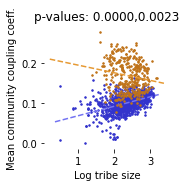

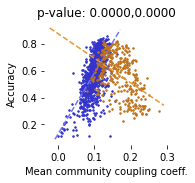

In [7]:
mtypes_l1_l5 = ['L1_DAC', 'L1_DLAC', 'L1_HAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SLAC', 'L23_BP', 'L23_BTC',
                   'L23_ChC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC', 'L23_PC', 'L23_SBC',
                   'L4_BP', 'L4_BTC', 'L4_ChC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC', 'L4_PC',
                   'L4_SBC', 'L4_SP', 'L4_SS', 'L5_BP', 'L5_BTC', 'L5_ChC', 'L5_DBC', 'L5_LBC', 'L5_MC',
                   'L5_NBC', 'L5_NGC', 'L5_SBC', 'L5_STPC', 'L5_TTPC1', 'L5_TTPC2', 'L5_UTPC']
mtypes_l6 = ['L6_BP', 'L6_BPC', 'L6_BTC', 'L6_ChC', 'L6_DBC', 'L6_IPC', 'L6_LBC', 'L6_MC', 'L6_NBC',
             'L6_NGC', 'L6_SBC', 'L6_TPC_L1', 'L6_TPC_L4', 'L6_UTPC']

dframe_tribes_coupl = assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params,
                                                 sampling="M-type", labels_to_iterate=mtypes_l1_l5,
                                                 parameters_to_add=spec_comm_coupling + ["Tribe size"])
dframe_tribes_coupl_l6 = assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params,
                                                   sampling="M-type", labels_to_iterate=mtypes_l6,
                                                   parameters_to_add=spec_comm_coupling + ["Tribe size"])

dframe_tribes_coupl["Log_tribe_size"] = numpy.log10(dframe_tribes_coupl["Tribe_size"])
dframe_tribes_coupl_l6["Log_tribe_size"] = numpy.log10(dframe_tribes_coupl_l6["Tribe_size"])


ax = plt.figure(figsize=(2.25, 2.25)).gca()
ax.plot(dframe_tribes_coupl["Log_tribe_size"],
        dframe_tribes_coupl["Mean_tribe_community_coupling"], '.', ms=3, color=[0.2, 0.2, 0.8])
model = ols("Mean_tribe_community_coupling ~ Log_tribe_size", data=dframe_tribes_coupl).fit()
ax.plot(ax.get_xlim(), model.params["Intercept"] +
        model.params["Log_tribe_size"] * numpy.array(ax.get_xlim()),
       ls='--', color=[0.45, 0.45, 0.95])

ax.plot(dframe_tribes_coupl_l6["Log_tribe_size"],
        dframe_tribes_coupl_l6["Mean_tribe_community_coupling"], '.', ms=3, color=[0.75, 0.45, 0.1])
model_l6 = ols("Mean_tribe_community_coupling ~ Log_tribe_size", data=dframe_tribes_coupl_l6).fit()
ax.plot(ax.get_xlim(), model_l6.params["Intercept"] +
        model_l6.params["Log_tribe_size"] * numpy.array(ax.get_xlim()),
       ls='--', color=[0.9, 0.6, 0.2])

ax.set_title("p-values: {0:5.4f},{1:5.4f}".format(model.pvalues["Log_tribe_size"],
                                       model_l6.pvalues["Log_tribe_size"]))
ax.set_xlabel("Log tribe size")
ax.set_ylabel("Mean community coupling coeff.")
plt.box(False)
F5.save(plt.gcf(), fn="Panel-A")

###

ax = plt.figure(figsize=(2.25,2.25)).gca()
ax.plot(dframe_tribes_coupl["Mean_tribe_community_coupling"],
        dframe_tribes_coupl["Accuracy"], '.', ms=3, color=[0.2, 0.2, 0.8])
model = ols("Accuracy ~ Mean_tribe_community_coupling", data=dframe_tribes_coupl).fit()
ax.plot(ax.get_xlim(), model.params["Intercept"] +
        model.params["Mean_tribe_community_coupling"] * numpy.array(ax.get_xlim()),
       ls='--', color=[0.45, 0.45, 0.95])

ax.plot(dframe_tribes_coupl_l6["Mean_tribe_community_coupling"],
        dframe_tribes_coupl_l6["Accuracy"], '.', ms=3, color=[0.75, 0.45, 0.1])
model_l6 = ols("Accuracy ~ Mean_tribe_community_coupling", data=dframe_tribes_coupl_l6).fit()
ax.plot(ax.get_xlim(), model_l6.params["Intercept"] +
        model_l6.params["Mean_tribe_community_coupling"] * numpy.array(ax.get_xlim()),
       ls='--', color=[0.9, 0.6, 0.2])

ax.set_title("p-value: {0:5.4f},{1:5.4f}".format(model.pvalues["Mean_tribe_community_coupling"],
                                      model_l6.pvalues["Mean_tribe_community_coupling"]))
ax.set_xlabel("Mean community coupling coeff.")
ax.set_ylabel("Accuracy")
plt.box(False)
F5.save(plt.gcf(), fn="Panel-B")

,specifier,Accuracy,Transitive_clustering_coefficient,Adjacency_spectral_gap_low,Relative_boundary,Fourth_density_coefficient,Normalized_Betti_coefficient,Fifth_density_coefficient,Afferent_extension_rate,Outdegree,Indegree,Efferent_extension_rate,Euler_characteristic,Mean_size,Mean_tribe_community_coupling,Accuracy_residual
0,125 um,0.342418,0.031502,0.011458,36.040905,4.119721e-07,0.203903,4.351548e-08,24927.391053,321.061158,298.286103,24540.696463,1266.777508,774.503333,0.090629,-0.318921
1,125 um,0.672785,0.032218,0.018509,33.951971,4.798793e-07,0.271887,5.816870e-08,25808.285610,308.937372,380.578938,24018.431315,1887.148860,801.597222,0.100380,0.039823
2,125 um,0.651928,0.031513,0.010049,33.550769,4.541027e-07,0.209899,5.289542e-08,24317.501609,318.368300,310.689520,24533.319424,1546.580068,623.260000,0.135809,-0.167815
3,125 um,0.574064,0.032245,0.017273,33.973113,4.618834e-07,0.256783,5.877952e-08,25510.384200,306.888007,374.563013,23970.328234,1819.585008,808.409506,0.091593,-0.051763
4,125 um,0.550334,0.031299,0.010568,33.925336,4.578383e-07,0.214702,5.486703e-08,24984.532292,327.002726,320.814420,24756.399092,1684.930937,740.958333,0.114861,-0.146138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,175 um,0.827864,0.033248,0.026776,29.784015,7.463353e-07,0.328109,1.327106e-07,26547.080417,296.689622,413.346317,23550.756136,3859.230572,659.460000,0.135820,0.046035
121,175 um,0.483686,0.031415,0.012022,32.763201,4.447236e-07,0.219599,4.669717e-08,25678.448400,323.607212,371.335514,24651.660022,1736.381952,761.296667,0.093248,-0.191485
122,175 um,0.556359,0.031692,0.013781,32.647967,4.060881e-07,0.216460,4.743090e-08,25635.008506,315.788191,415.280116,24333.673251,1690.423646,753.878333,0.081066,-0.126581
123,175 um,0.412866,0.031555,0.011661,34.048349,4.082942e-07,0.205516,2.860101e-08,25012.106092,318.440570,306.386886,24471.533211,1389.617506,740.935000,0.075573,-0.283630


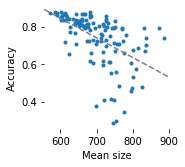

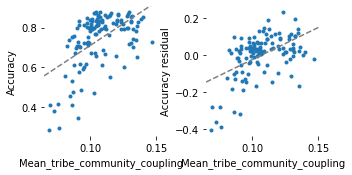

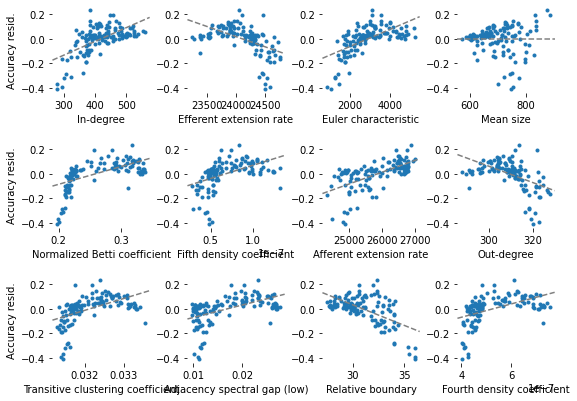

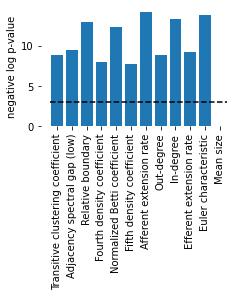

In [9]:
#from pandas_helper import sanitize_param_name
def sanitize_param_name(param):
        param_label = param.replace(" ", "_")
        return "".join([_x for _x in param_label if _x not in ")(-+"])

'''parameters_to_check = ["Mean tribe community coupling",
                      "Relative boundary",
                      "Transitive clustering coefficient",
                      "Afferent extension rate",
                      "Second density coefficient",
                      "Euler characteristic"]'''
#parameters_fig5 = ["Mean tribe community coupling"]
parameters_fig5 = ["Accuracy", "Accuracy residual"]


dframe_vol_coupl = assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params,
                                             sampling="Radius",
                                             parameters_to_add=spec_parameters + ["Mean size",
                                                                                 "Mean tribe community coupling"])

model = ols("Accuracy ~ Mean_size", data=dframe_vol_coupl).fit()
dframe_vol_coupl["Accuracy_residual"] = model.resid.values

display(dframe_vol_coupl)

fig = plt.figure(figsize=(2.25, 2.25))
ax = fig.gca()
ax.plot(dframe_vol_coupl["Mean_size"],
       dframe_vol_coupl["Accuracy"], '.')
ax.set_ylim(ax.get_ylim()); ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), model.params["Intercept"] +
        model.params["Mean_size"] * numpy.array(ax.get_xlim()),
        ls='--', color="gray")
ax.set_xlabel("Mean size")
ax.set_ylabel("Accuracy")
plt.box(False)

F.save(fig, "Panel-D")

fig = plt.figure(figsize=(4.5, 2.25))
i=1
for i, param in enumerate(parameters_fig5):
    san_param = sanitize_param_name(param)
    x = numpy.mod(i, 2); y = numpy.floor(i / 2)
    ax = fig.add_axes([0.05 + x * 0.5, 0.05 + y * 1.0, 0.35, 0.8])

    ax.plot(dframe_vol_coupl["Mean_tribe_community_coupling"],
            dframe_vol_coupl[san_param], '.')
    ax.set_ylim(ax.get_ylim()); ax.set_xlim(ax.get_xlim())
    model = ols("{0} ~ Mean_tribe_community_coupling".format(san_param), data=dframe_vol_coupl).fit()
    ax.plot(ax.get_xlim(), model.params["Intercept"] +
            model.params["Mean_tribe_community_coupling"] * numpy.array(ax.get_xlim()),
            ls='--', color="gray")
    ax.set_xlabel("Mean_tribe_community_coupling")
    # ax.set_title("p-value: {0:5.4f}".format(model.pvalues[san_param]))
    ax.set_ylabel(param)
    plt.box(False)
    
F5.save(fig, fn="Some-panel")



fig = plt.figure(figsize=(7.5, 7.5))
i=1
p_vals = []
for i, param in enumerate(spec_parameters + ["Mean size"]):
    san_param = sanitize_param_name(param)
    x = numpy.mod(i, 4); y = numpy.floor(i / 4)
    ax = fig.add_axes([0.05 + x * 0.25, 0.05 + y * 0.25, 0.18, 0.16])

    ax.plot(dframe_vol_coupl[san_param],
            dframe_vol_coupl["Accuracy_residual"], '.')
    ax.set_ylim(ax.get_ylim()); ax.set_xlim(ax.get_xlim())
    model = ols("Accuracy_residual ~ {0}".format(san_param), data=dframe_vol_coupl).fit()
    ax.plot(ax.get_xlim(), model.params["Intercept"] +
            model.params[san_param] * numpy.array(ax.get_xlim()),
            ls='--', color="gray")
    ax.set_xlabel(param)
    p_vals.append(model.pvalues[san_param])
    if i in [0, 4, 8, 12]:
        ax.set_ylabel("Accuracy resid.")
    plt.box(False)
    
S.save(fig, fn="Panel-all-params")

fig = plt.figure(figsize=(3.5, 2.2))
ax = fig.gca()
ax.bar(numpy.arange(len(spec_parameters) + 1),
       -numpy.log10(p_vals),
       width=0.8)
p_thresh = 0.01; p_thresh_corr = p_thresh / len(p_vals)
ax.plot([-0.5, len(p_vals) - 0.5],
       -numpy.log10(p_thresh_corr) * numpy.ones(2), color='black', ls='--')
ax.set_xticks(range(len(p_vals)))
_ = ax.set_xticklabels(spec_parameters + ["Mean size"], rotation='vertical')
ax.set_ylabel("negative log p-value")
plt.box(False)
F.save(fig, fn="Panel-E")
